In [42]:
# load packages
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.io import RawArray
import numpy.matlib
import scipy.stats as stats 
sns.set_theme() # set the plotting atmosphere

In [43]:
NumHarms = 4
NumBins = 6
NumHemis = 2
NumChans = 128

GoodDataDims = NumHarms*NumBins*NumHemis
GoodKeyDicts = NumHarms*NumHemis

In [44]:
# montage info 
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

def init_TopoTemplate(title_In):
    """Prep topo plot fig and axes"""
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].gridspec_kw=dict(height_ratios=[3])
    axes[1].gridspec_kw=dict(height_ratios=[3])
    plt.tight_layout()
    plt.suptitle(f'{title_In}', fontsize = 20)
    #axes[0].set_title(f'{title_In}', fontsize = 20)
    #axes[1].set_title(f'{title_In}', fontsize = 20)
    return fig, axes

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>


In [45]:
contrast_levels=np.array([1, 3, 5, 16, 40, 100])
cll=['1%', '3%', '5%', '16%', '40%', '100%']
ttl = ['2f1','4f1','6f1','8f1','2f2','4f2','6f2','8f2']

elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
elec_Arc4_inner = [71,67,62,77,76,75,     72]
AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
#AllAnalysisChans = np.concatenate([elec_Arc2,elec_Arc3,elec_Arc4_inner])
AnalysisChans = np.unique(AllAnalysisChans) - 1
VisChans = np.sort(AnalysisChans)
print(f'Channels to be visualized: {VisChans}')
ch_list = np.arange(0,NumChans,1)
ocm = np.zeros_like((ch_list))
ocm[VisChans] = True # set good chans to true
ocm_chans = ocm.astype(bool)

Channels to be visualized: [30 36 41 46 50 51 52 53 54 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97]


In [61]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\LTP_analysis\\Control_ltp_Data' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {len(dataFileNames)}')
##############################################
FileN = dataFileNames[0]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: 1
Current WD: C:\plimon\LTP_analysis\Control_ltp_Data\nl-ryanltpstimuluste_20240430_1222_RLS.mat
Does File #1 Exist? True


In [47]:
mat_data = scipy.io.loadmat(file_path1) # import data file
print((mat_data.keys()))

dict_keys(['__header__', '__version__', '__globals__', 'info', 'signalData', 'noise1', 'noise2'])


In [48]:
# find basic data parms 
MainData = mat_data['signalData']
noise1 = mat_data['noise1'] # 6 x 1 
noise2 = mat_data['noise2']
inds = mat_data['info'][0][0]
ExpConds = int(MainData.shape[0])
print(f'Data file contains data for {ExpConds} different conditions')

Data file contains data for 6 different conditions


In [49]:
# save signal data
FreqDataPerCo = {}
for co in range(ExpConds):
    #print(MainData[co][0].shape)
    FreqDataPerCo[co] = MainData[co][0]

In [50]:
print(FreqDataPerCo.keys())
for i in range(6):
    print(FreqDataPerCo[i].shape)

dict_keys([0, 1, 2, 3, 4, 5])
(112, 128, 13)
(112, 128, 13)
(112, 128, 13)
(112, 128, 13)
(112, 128, 13)
(112, 128, 13)


In [51]:
print(f'each key contains different control stim that we ran during the stim param manipulations' )
print(FreqDataPerCo.keys())

each key contains different control stim that we ran during the stim param manipulations
dict_keys([0, 1, 2, 3, 4, 5])


In [52]:
x = FreqDataPerCo[5]
y = x[:,:,1:] # remove avg trial activity
splitInd = int(np.shape(y)[0] / 2)
# freq inds x real/imaginary x allchans x trials
z = np.reshape(y,newshape = (splitInd,2,128,12),order = 'A')
binCuts = int(56/7)
bc_inds = np.arange(0,56,7)
print(bc_inds)
print(z.shape)

DataOut = {} # index based on 7 numbins total
# for bc in range(7):
for bc in range(len(bc_inds)):
    start = bc_inds[bc]
    endInd = start + 7
    # 8 keys per 2 4 6 8 F1, F2
    DataOut[bc] = z[start:endInd,:,:,:] # binx x ri x ch x trials
# remove prelude! 
CleanSignal = {}
for cs in range(8):
    preludeInc = DataOut[cs] # import 1 data array, remove prelude bin
    temp = preludeInc[1:,:,:,:]
    CleanSignal[cs] = temp
# print(f'Num Keys 2468 F1/F2: {CleanSignal.keys()}')

[ 0  7 14 21 28 35 42 49]
(56, 2, 128, 12)


In [53]:

BinChanActs = {}
#print((b[0,0,101,:].shape))
# Contrast_ChanAct = np.zeros((6,128)) # avg channel activty across trials

for co in range(8): # import all hamonic and hemi field data
    Contrast_ChanAct = np.zeros((6,128)) # avg channel activty across trials'
    hdIn = CleanSignal[co]
    for bb in range(6):
        for ch in range(128):
            mdIn = np.nanmean(hdIn[bb,0,ch,:])
            mi = np.nanmean(hdIn[bb,1,ch,:])
            hy = np.hypot(mdIn,mi)
            Contrast_ChanAct[bb,ch] = hy
    BinChanActs[co] = Contrast_ChanAct

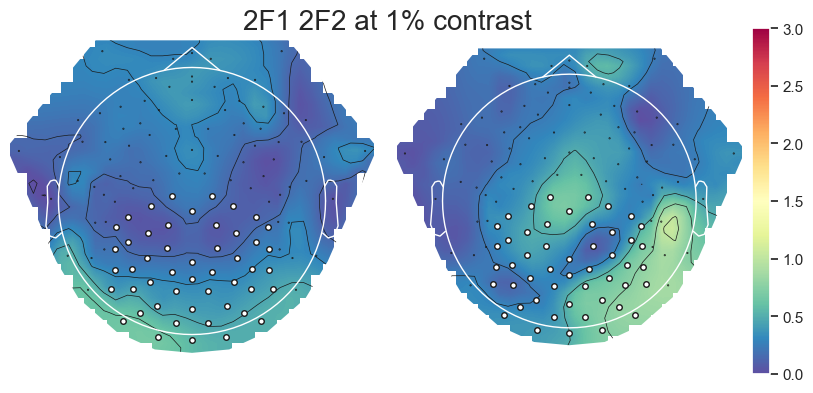

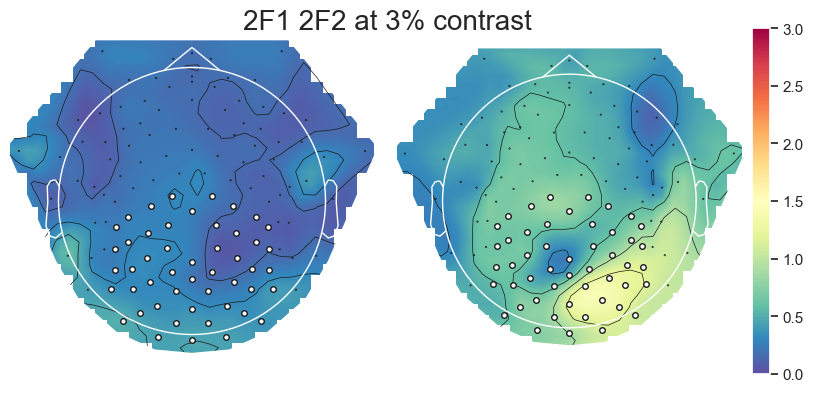

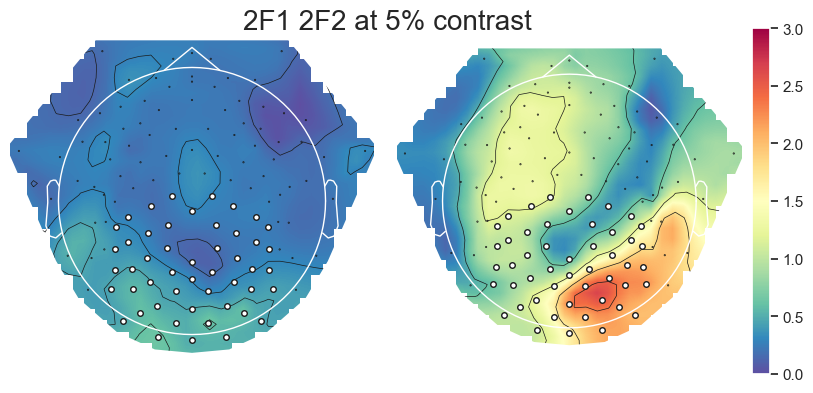

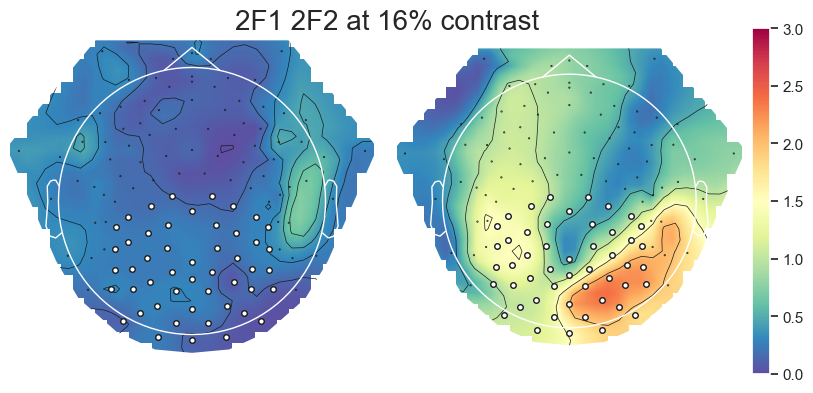

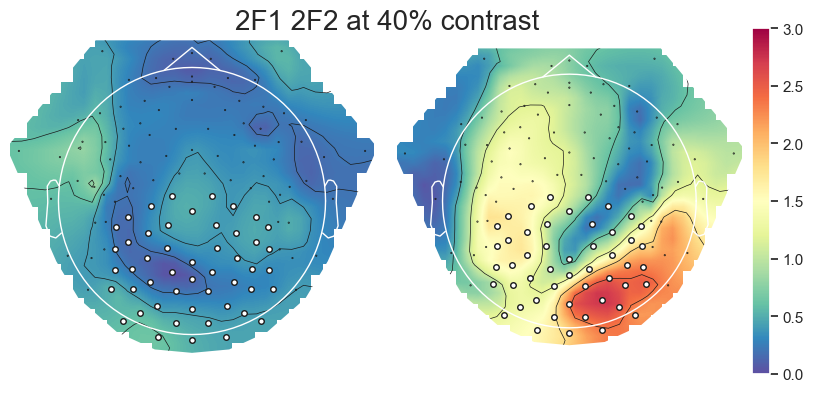

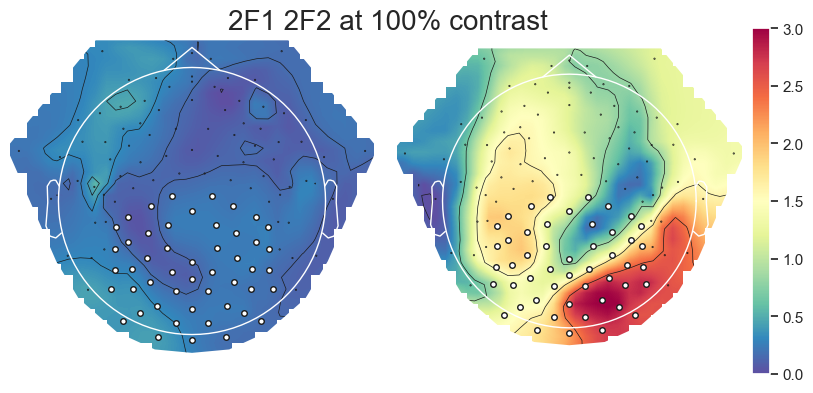

In [58]:
for bin in range(6):
    tIn_F1 = BinChanActs[0][bin,:]
    tIn_F2 = BinChanActs[4][bin,:]
    # findLims = np.vstack((tIn_F1,tIn_F2))
    # print(findLims.shape)
    # t_max = np.max(findLims)
    # t_min = np.min(findLims)
    # print(t_min,t_max)
    v_max = 3
    v_min = 0

    fig, axes = init_TopoTemplate(f'2F1 2F2 at {cll[bin]} contrast')
    # left side plot
    im,_ = plot_topomap(tIn_F1, info,mask = ocm,vlim=[v_min,v_max], axes = axes[0], show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(tIn_F2, info,mask = ocm,vlim=[v_min,v_max], axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

#### make sure below makes sense before incorporating it 

In [ ]:
coCall = 0
coData  = FreqDataPerCo[coCall]
coData = coData[:,:,1:]

[NumRows, NumChans, NumTrials] = coData.shape # get dims of data to use later ..
print(f'DataVals, Channels , Total Trials: {coData.shape}')
real_imag_bound = int((NumRows/2))
print(f'Data real-imag bound is at row: #{real_imag_bound}')
chanInd = np.arange(0,NumChans,1)
print(f'total channels: {chanInd.shape}')
prepost_bound = int(NumTrials/2)
HemiBound = int((coData.shape[0]) / 2)
print(HemiBound)

### get / set harmonic and hemifield indicies
harmLab = np.ravel(mat_data['info'][0][0] [0][co][0])
HarmInd = []
for h in range(len(harmLab)):
    HarmInd.append(harmLab[h][0])
hh_iters = int(len(HarmInd)) # [2f1 4f 6f 8f    2f2 4f 6f 8f]
hh_bool = np.arange(0,hh_iters,1) 
# print(hh_bool)
### Get bin index
BinInd = np.ravel(mat_data['info'][0][0] [1][co][0])
# print(BinInd)

hh_array = np.tile(hh_bool,7)
bin_array = np.tile(BinInd,8)

In [ ]:
NumHarms,NumHarmCount = np.unique(hh_array, return_counts = True)
print(f'Hamronics:  {NumHarms,NumHarmCount}')
NumBins,NumBinCount = np.unique(bin_array, return_counts = True)
print(f'Bin Indicies:  {NumBins,NumBinCount}')
Bins = int(len(NumBins)-1)
print(f'Total Bins #{Bins}')

In [ ]:
# Reshape data into real and imaginary data side by side
dIn = coData.reshape(real_imag_bound,2,NumChans,NumTrials, order = 'A') # 56 x 2 x 128 x 78
# Clean Data
dIn[dIn == 0] = np.nan # remove 0s -> nans
print(dIn.shape) # [vals x real/imag x channels x total trials]

In [ ]:
xF_Bins = {}

for hi in range(len(hh_bool)):
    xF_Bins[hi] = dIn[hh_array == hi,:,:]
    # print(xF_Bins[hi].shape[0])
    #binCount = int(xF_Bins[hi].shape[0])
    if int(xF_Bins[hi].shape[0]) != 6:
        #print(f'extra trial')
        temp=xF_Bins[hi][1:,:,:,:] # all data w/o 0th row (not relevant data)
        xF_Bins[hi] = temp

In [ ]:
print(xF_Bins[0].shape)

In [ ]:
data = {}

for freqIters in range(GoodKeyDicts):
    xt_comb = np.zeros((6,128))
    # print(xt_comb.shape)
    xIn = xF_Bins[freqIters] # bin x r/i x channels x trials
    # print(xIn.shape)
    for bin in range(6):
        for ch in range(128):
            #print(xIn[bin,0,ch,:].shape) # imarinary vals per bin
            xt_comb[bin,ch] = np.hypot(np.nanmean(xIn[bin,0,ch,:]),np.nanmean(xIn[bin,1,ch,:]))
            # # print(bin)
    data[freqIters] = xt_comb

In [ ]:
print(data[0].shape)

h2data = [data[0], data[4]]

In [ ]:
print(h2data[0].shape)
for b in range(6):
    plt.plot(h2data[0][b,:], label = f'bin {b+1}')
plt.legend()
plt.show()

In [ ]:
for bin in range(6):
    tIn_F1 = h2data[0][b,:]
    tIn_F2 = h2data[1][b,:]
    fig, axes = init_TopoTemplate(f'2F1 2F2 at {cll[bin]} contrast')
    # left side plot
    im,_ = plot_topomap(tIn_F1, info,mask = ocm, axes = axes[0], show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
    # middle  plot
    im,_ = plot_topomap(tIn_F2, info,mask = ocm, axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)

In [ ]:
# co = 4 # pre and post induction ltp
# harmLab = np.ravel(mat_data['info'][0][0] [0][co][0])
# BinInd = np.ravel(mat_data['info'][0][0] [1][co][0])
# HarmInd = []
# for h in range(len(harmLab)):
#     HarmInd.append(harmLab[h][0])


In [ ]:
# NumHarms,NumHarmCount = np.unique(HarmInd, return_counts = True)
# print(f'Hamronics:  {NumHarms,NumHarmCount}')
# NumBins,NumBinCount = np.unique(BinInd, return_counts = True)
# print(f'Bin Indicies:  {NumBins,NumBinCount}')
# Bins = int(len(NumBins)-1)
# print(f'Total Bins #{Bins}')

In [ ]:
# SortDataIn =  FreqDataPerCo[co] # 112 x 128 x 78
# SortDataIn = SortDataIn[:,:,1:] # rmv avg trial activity (1st row)

# [NumRows, NumChans, NumTrials] = SortDataIn.shape # get dims of data to use later ..
# print(f'DataVals, Channels , Total Trials: {SortDataIn.shape}')
# real_imag_bound = int((NumRows/2))
# print(f'Data real-imag bound is at row: #{real_imag_bound}')
# chanInd = np.arange(0,NumChans,1)
# print(f'total channels: {chanInd.shape}')
# prepost_bound = int(NumTrials/2)
# HemiBound = int((SortDataIn.shape[0]) / 2)
# print(HemiBound)
#HemiBound = int(int(len(HemiFieldLabels))/2)
# print(f'Data will be split at the 4th row when called for hemifield segmentation')

In [ ]:
# # bi = np.tile(BinInd,8)
# hi = np.arange(0,8,1)
# harmonicIndex = np.tile(hi,7)

# print(len(HarmInd))
# NumBins = 6

In [ ]:
# # Reshape data into real and imaginary data side by side
# dIn = SortDataIn.reshape(real_imag_bound,2,NumChans,NumTrials, order = 'A') # 56 x 2 x 128 x 78
# # Clean Data
# # remove 0s -> nans
# dIn[dIn == 0] = np.nan

# xF_Bins = {}
# for hi in range(len(HarmInd)):
#     xF_Bins[hi] = dIn[harmonicIndex == hi,:,:]
#     if int(xF_Bins[hi].shape[0])!=(NumBins): # remove prelude / avg contrast activity
#         temp=xF_Bins[hi][1:,:,:,:] # all data w/o 0th row (not relevant data)
#         xF_Bins[hi]=temp
#         print(xF_Bins[hi].shape)

In [ ]:
# NumHarms = 4
# NumBins = 6
# NumHemis = 2

# GoodDataDims = NumHarms*NumBins*NumHemis
# GoodKeyDicts = NumHarms*NumHemis

In [ ]:
# data = {}
# for freqIters in range(8):
#     xt_comb = np.zeros((NumBins,NumChans)) 
#     dIn = xF_Bins[freqIters]

#     for bin in range(NumBins):
#             for ch in range(NumChans):
#                 xt_comb[bin,ch] = np.hypot(np.nanmean(dIn[bin,0,ch,:]),np.nanmean(dIn[bin,1,ch,:])) # pre
#                 #xt_comb[bin,1,ch] = np.hypot(np.nanmean(dIn[bin,0,ch,inds[1]:inds[2]]),np.nanmean(dIn[bin,1,ch,inds[1]:inds[2]])) # post
#             data[freqIters] = xt_comb

In [ ]:
# print(data[0].shape)

# h2data = [data[0], data[4]]

In [ ]:
# print(h2data[0].shape)


# for b in range(NumBins):
#     plt.plot(h2data[0][b,:], label = f'bin {b+1}')
# plt.legend()
# plt.show()

### plot some topos of data

In [ ]:
# # montage info 
# montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
# info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
# info.set_montage(montageIn)
# print(montageIn)

In [ ]:
# def init_TopoTemplate(title_In):
#     """Prep topo plot fig and axes"""
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4)) # ,gridspec_kw=dict(height_ratios=[3]), layout = 'constrained'
#     axes[0].axis('off')
#     axes[1].axis('off')
#     axes[0].gridspec_kw=dict(height_ratios=[3])
#     axes[1].gridspec_kw=dict(height_ratios=[3])
#     plt.tight_layout()
#     plt.suptitle(f'{title_In}', fontsize = 20)
#     #axes[0].set_title(f'{title_In}', fontsize = 20)
#     #axes[1].set_title(f'{title_In}', fontsize = 20)
#     return fig, axes

In [ ]:
# NumBins = 6
# NumChans = 128
# contrast_levels=np.array([1, 3, 5, 16, 40, 100])
# contrast_levels_labs=['1%', '3%', '5%', '16%', '40%', '100%']
# cll=['1%', '3%', '5%', '16%', '40%', '100%']
# ttl = ['2f1','4f1','6f1','8f1','2f2','4f2','6f2','8f2']
# elec_Arc1_outer = [68,64,58,51,47,42,37,31,    80,87,93,98,97,96,95,94]
# elec_Arc2 = [73,69,65,59,52,53,54,  55,  79,86,92,91,90,89,88]
# elec_Arc3 = [74,70,66,60,61,  78,85,84,83,82,  81]
# elec_Arc4_inner = [71,67,62,77,76,75,     72]
# AllAnalysisChans = np.concatenate([elec_Arc1_outer,elec_Arc2,elec_Arc3,elec_Arc4_inner])
# #AllAnalysisChans = np.concatenate([elec_Arc2,elec_Arc3,elec_Arc4_inner])
# AnalysisChans = np.unique(AllAnalysisChans) - 1
# VisChans = np.sort(AnalysisChans)
# print(f'Channels to be visualized: {VisChans}')
# ch_list = np.arange(0,NumChans,1)
# ocm = np.zeros_like((ch_list))
# ocm[VisChans] = True # set good chans to true
# ocm_chans = ocm.astype(bool)

In [ ]:
# for bin in range(NumBins):
#     tIn_F1 = h2data[0][b,:]
#     tIn_F2 = h2data[1][b,:]
#     fig, axes = init_TopoTemplate(f'2F1 2F2 at {cll[bin]} contrast')
#     # left side plot
#     im,_ = plot_topomap(tIn_F1, info,mask = ocm, axes = axes[0], show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')
#     # middle  plot
#     im,_ = plot_topomap(tIn_F2, info,mask = ocm, axes = axes[1],show =False,extrapolate = 'local',cmap = 'Spectral_r', res = 32, contours =4,sphere=(0.0,0.0,0.0,0.09),outlines = 'head')

#     divider = make_axes_locatable(axes[1])
#     cax = divider.append_axes('right', size='5%', pad=0.1)
#     cbar = plt.colorbar(im, cax=cax)

In [ ]:
bi = np.tile(BinInd,8)
print(bi.shape)


In [ ]:
dataPerBin = {}
for i in range(len(NumBins)):
    if i > 0:
        bin_arr = np.zeros_like((bi))
        bin_arr[bi == i] = 1 # changr bool ind to get bin specific data
        dataPerBin[i-1] = DataOut[bi == 1,:,:]

In [ ]:
print(dataPerBin[0].shape)

In [ ]:
colDim = np.shape(dataPerBin[0])[0]
print(colDim)
if colDim != (8):
    temp_dataPerBin = {} # write over original data in temp

    print(f'1F1 data is included, now removing this data...')

    for i in range(int(len(NumBins))-1):
        dOut = dataPerBin[i][1:,:,:]
        print(f'Data out dims: {dOut.shape}')
        temp_dataPerBin[i] = dOut
        print(f'All Done! :)')
    print(f'Data shapes are now good!')
    
    dataPerBin = temp_dataPerBin # rewrite over old data

else:
    print(f'Data is correct dims!')

In [ ]:
print(dataPerBin[0].shape)